In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np

In [9]:
clinical_attributes = pd.read_csv('step_04/clinical_attributes.csv')
z_score = pd.read_csv('step_04/z_score.csv')
mutation = pd.read_csv('step_04/mutation.csv')
response = pd.read_csv('step_04/response.csv')

In [10]:
response

,overall_survival
0,1
1,0
2,1
3,1
4,1
...,...
1177,0
1178,1
1179,1
1180,0


## Separación en ( train (80) + val (20) )[90] + test [10]

In [11]:
seed = 255

In [12]:
X_clinical_train_val, X_clinical_test, y_train_val, y_test = train_test_split(clinical_attributes, response, test_size=0.1, random_state=seed)
X_clinical_train, X_clinical_val, y_train, y_val = train_test_split(X_clinical_train_val, y_train_val, test_size=0.2, random_state=seed)

X_mutation_train_val, X_mutation_test, _, _ = train_test_split(mutation, response, test_size=0.1, random_state=seed)
X_mutation_train, X_mutation_val, _, _ = train_test_split(X_mutation_train_val, y_train_val, test_size=0.2, random_state=seed)

X_z_score_train_val, X_z_score_test, _, _ = train_test_split(z_score, response, test_size=0.1, random_state=seed)
X_z_score_train, X_z_score_val, _, _ = train_test_split(X_z_score_train_val, y_train_val, test_size=0.2, random_state=seed)

# Model testing

In [20]:
from joblib import dump

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification


In [32]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary'),
    'mcc': make_scorer(matthews_corrcoef)
}

## General (Punto 1)

In [14]:
class Datasets():
    def __init__(self, seed):
        X_clinical_train_val, X_clinical_test, y_train_val, y_test = train_test_split(clinical_attributes, response, test_size=0.1, random_state=seed)
        X_clinical_train, X_clinical_val, y_train, y_val = train_test_split(X_clinical_train_val, y_train_val, test_size=0.2, random_state=seed)

        X_mutation_train_val, X_mutation_test, _, _ = train_test_split(mutation, response, test_size=0.1, random_state=seed)
        X_mutation_train, X_mutation_val, _, _ = train_test_split(X_mutation_train_val, y_train_val, test_size=0.2, random_state=seed)

        X_z_score_train_val, X_z_score_test, _, _ = train_test_split(z_score, response, test_size=0.1, random_state=seed)
        X_z_score_train, X_z_score_val, _, _ = train_test_split(X_z_score_train_val, y_train_val, test_size=0.2, random_state=seed)

        self.datasets = [
            ("clinical", X_clinical_train, X_clinical_val, X_clinical_test),
            ("mutation", X_mutation_train, X_mutation_val, X_mutation_test),
            ("z_score", X_z_score_train, X_z_score_val, X_z_score_test)
        ]
        
    def __iter__(self):
        for dataset in self.datasets:
            yield dataset

In [65]:
class Models():
    algorithms = [
        ("knn", KNeighborsClassifier()),
        ("dt", DecisionTreeClassifier()),
        ("svm", SVC()),
        ("rf", RandomForestClassifier()),
        ("ada", AdaBoostClassifier()) 
    ]
    
    def train_all(self, data, response):
        for name, algorithm in self.algorithms:
            algorithm.fit(X=data, y=response)

    def save(self, sufix):
        for name, algorithm in self.algorithms:
            dump(algorithm, f"models/{name}_model_{sufix}.joblib")

    def predict(self, X_val):
        predictions = []

        for name, model in self.algorithms:
            predictions.append((name, model.predict(X_val)))
        
        return predictions
    
    def cross_validate_model(self, name, model, X, y, cv, scoring):
        res = cross_validate(model, X, y, cv=cv, scoring=scoring)
        return [name, res["test_accuracy"].mean(), res["test_precision"].mean(), res["test_recall"].mean(), res["test_f1"].mean(), res["test_mcc"].mean()]
    
    def cross_validate(self, X, y, cv, scoring):
        score_list = []
        for name, model in self.algorithms:
            score_list.append(self.cross_validate_model(name, model, X, y, cv, scoring))
        
        return pd.DataFrame(score_list, columns=["algorithm", "accuracy", "precision", "recall", "f1", "mcc"])

    def cv_predict(self, X, y, cv):
        self.predictions = cross_val_predict(self.model_instance, X, y, cv=cv)
        return self.get_metrics(y)

    def get_metrics(self, X_val,y_true):
        export_list = []
        predictions = self.predict(X_val)
        for name, y_pred in predictions:
            acc_value = accuracy_score(y_pred=y_pred, y_true=y_true) 
            recall_value = recall_score(y_pred=y_pred, y_true=y_true)
            precision_value = precision_score(y_pred=y_pred, y_true=y_true) 
            f1_value = f1_score(y_pred=y_pred, y_true=y_true)
            mcc_value = matthews_corrcoef(y_pred=y_pred, y_true=y_true)
            cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
            export_list.append((name, acc_value, recall_value, precision_value, f1_value, mcc_value, cm))
    
        return pd.DataFrame(export_list, columns=["algorithm", "acc", "recall", "precision", "f1", "mcc", "cm"])

In [16]:
model_instance = Models()
model_instance.train_all(X_clinical_train, y_train)
metrics_val = model_instance.get_metrics(X_clinical_val, y_val)
metrics_test = model_instance.get_metrics(X_clinical_test, y_test)
metrics = pd.merge(metrics_val, metrics_test, on="algorithm", suffixes=('_val', '_test'))
metrics

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A

,algorithm,acc_val,recall_val,precision_val,f1_val,mcc_val,cm_val,acc_test,recall_test,precision_test,f1_test,mcc_test,cm_test
0,knn,0.596244,0.520408,0.566667,0.542553,0.182908,"[[76, 39], [47, 51]]",0.621849,0.666667,0.593750,0.628099,0.247803,"[[36, 26], [19, 38]]"
1,dt,0.544601,0.561224,0.504587,0.531401,0.091392,"[[61, 54], [43, 55]]",0.630252,0.649123,0.606557,0.627119,0.261878,"[[38, 24], [20, 37]]"
2,svm,0.638498,0.602041,0.608247,0.605128,0.271823,"[[77, 38], [39, 59]]",0.689076,0.754386,0.651515,0.699187,0.385386,"[[39, 23], [14, 43]]"
3,rf,0.643192,0.581633,0.619565,0.600000,0.278998,"[[80, 35], [41, 57]]",0.680672,0.719298,0.650794,0.683333,0.364769,"[[40, 22], [16, 41]]"
4,ada,0.643192,0.642857,0.605769,0.623762,0.285501,"[[74, 41], [35, 63]]",0.714286,0.719298,0.694915,0.706897,0.428612,"[[44, 18], [16, 41]]"


In [ ]:
# No usar
seeds = [42, 255, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
metrics = pd.DataFrame(columns=["seed", "algorithm", "acc_val", "recall_val", "precision_val", "f1_val", "mcc_val", "cm_val", "acc_test", "recall_test", "precision_test", "f1_test", "mcc_test", "cm_test"])
for seed in seeds:
    datasets = Datasets(seed)
    print(f"running {name}")
    model_instance = Models()
    model_instance.train_all(X_train, y_train)
    metrics_val = model_instance.get_metrics(X_val, y_val)
    metrics_test = model_instance.get_metrics(X_test, y_test)
    metrics_val_test = pd.merge(metrics_val, metrics_test, on="algorithm", suffixes=('_val', '_test'))
    metrics = pd.merge(metrics, metrics_val_test, on="algorithm", suffixes=('_val', '_test'))
metrics

model_instance = Models()
model_instance.train_all(X_clinical_train, y_train)
metrics_val = model_instance.get_metrics(X_clinical_val, y_val)
metrics_test = model_instance.get_metrics(X_clinical_test, y_test)
metrics = pd.merge(metrics_val, metrics_test, on="algorithm", suffixes=('_val', '_test'))
metrics

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A

,algorithm,acc_val,recall_val,precision_val,f1_val,mcc_val,cm_val,acc_test,recall_test,precision_test,f1_test,mcc_test,cm_test
0,knn,0.610329,0.540816,0.582418,0.560847,0.211967,"[[77, 38], [45, 53]]",0.554622,0.631579,0.529412,0.576000,0.116543,"[[30, 32], [21, 36]]"
1,dt,0.568075,0.581633,0.527778,0.553398,0.137727,"[[64, 51], [41, 57]]",0.605042,0.596491,0.586207,0.591304,0.209276,"[[38, 24], [23, 34]]"
2,svm,0.629108,0.602041,0.595960,0.598985,0.254034,"[[75, 40], [39, 59]]",0.655462,0.684211,0.629032,0.655462,0.313243,"[[39, 23], [18, 39]]"
3,rf,0.638498,0.602041,0.608247,0.605128,0.271823,"[[77, 38], [39, 59]]",0.705882,0.736842,0.677419,0.705882,0.414261,"[[42, 20], [15, 42]]"
4,ada,0.643192,0.642857,0.605769,0.623762,0.285501,"[[74, 41], [35, 63]]",0.714286,0.719298,0.694915,0.706897,0.428612,"[[44, 18], [16, 41]]"


## Mini analisis

- **KNN**: similar resultados en validacion y testeo
- **DT**: Tiene una diferencia bastante grande en f1 score lo que PODRIA indicar overfiting (Hay que ver si se comporta similar con otras semillas)
- **SVM**: similar resultados en validacion y testeo. Generaliza mejor
- **RF**: Buena consistencia en recall pero baja performance en MCC entre validacion y test. Pero no teiene tanto overfitting.
- **Adaboost**: Generaliza bien y da por poquito los mejores resultados.

DT es el que tiene mas sobreajuste

In [ ]:
model_instance = Models()
model_instance.train_all(X_z_score_train, y_train)
metrics_val = model_instance.get_metrics(X_z_score_val, y_val)
metrics_test = model_instance.get_metrics(X_z_score_test, y_test)
metrics = pd.merge(metrics_val, metrics_test, on="algorithm", suffixes=('_val', '_test'))
metrics

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A

,algorithm,acc_val,recall_val,precision_val,f1_val,mcc_val,cm_val,acc_test,recall_test,precision_test,f1_test,mcc_test,cm_test
0,knn,0.624413,0.642857,0.583333,0.611650,0.250775,"[[70, 45], [35, 63]]",0.638655,0.736842,0.600000,0.661417,0.289521,"[[34, 28], [15, 42]]"
1,dt,0.558685,0.540816,0.519608,0.530000,0.114466,"[[66, 49], [45, 53]]",0.563025,0.614035,0.538462,0.573770,0.130608,"[[32, 30], [22, 35]]"
2,svm,0.657277,0.653061,0.621359,0.636816,0.313098,"[[76, 39], [34, 64]]",0.697479,0.736842,0.666667,0.700000,0.398471,"[[41, 21], [15, 42]]"
3,rf,0.629108,0.663265,0.585586,0.622010,0.262660,"[[69, 46], [33, 65]]",0.689076,0.789474,0.642857,0.708661,0.392060,"[[37, 25], [12, 45]]"
4,ada,0.582160,0.581633,0.542857,0.561576,0.163734,"[[67, 48], [41, 57]]",0.630252,0.701754,0.597015,0.645161,0.268174,"[[35, 27], [17, 40]]"


## Mini analisis

- **KNN**: Hay una mejora pequeña en las metricas.
- **DT**: Presenta una pequeña mejora en test pero no es tanto sobreajuste.
- **SVM**: Es el mejor de todas las metricas especialmente en F1 y MCC.
- **RF**: Muestra una mejora en test por lo que se traduce a una mejora en generalizacion
- **ADA**: Majora en test especialmente en F1-Score y MCC lo que indica una buena generalizacion.

In [ ]:
model_instance = Models()
model_instance.train_all(X_mutation_train, y_train)
metrics_val = model_instance.get_metrics(X_mutation_val, y_val)
metrics_test = model_instance.get_metrics(X_mutation_test, y_test)
metrics = pd.merge(metrics_val, metrics_test, on="algorithm", suffixes=('_val', '_test'))
metrics

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A

,algorithm,acc_val,recall_val,precision_val,f1_val,mcc_val,cm_val,acc_test,recall_test,precision_test,f1_test,mcc_test,cm_test
0,knn,0.427230,0.530612,0.406250,0.460177,-0.132571,"[[39, 76], [46, 52]]",0.478992,0.578947,0.464789,0.515625,-0.034578,"[[24, 38], [24, 33]]"
1,dt,0.525822,0.540816,0.486239,0.512077,0.053703,"[[59, 56], [45, 53]]",0.495798,0.526316,0.476190,0.500000,-0.005947,"[[29, 33], [27, 30]]"
2,svm,0.577465,0.642857,0.533898,0.583333,0.165036,"[[60, 55], [35, 63]]",0.504202,0.491228,0.482759,0.486957,0.007353,"[[32, 30], [29, 28]]"
3,rf,0.568075,0.632653,0.525424,0.574074,0.146086,"[[59, 56], [36, 62]]",0.521008,0.508772,0.500000,0.504348,0.041007,"[[33, 29], [28, 29]]"
4,ada,0.572770,0.612245,0.530973,0.568720,0.151174,"[[62, 53], [38, 60]]",0.428571,0.385965,0.400000,0.392857,-0.146584,"[[29, 33], [35, 22]]"


## Mini analisis

- **KNN**: Buena generalizacion pero tiene un MCC bajo lo cual indica que no es un buen modelo
- **DT**: Buena generalizacion pero tiene un MCC bajo lo cual indica que no es un buen modelo
- **SVM**: Los resultados en testo son peores en todas las metricas lo cual indica un posible sobreajuste
- **RF**:  Las metricas son peores en MCC y Recall, posible sobreajuste
- **ADA**: Muestra un fuerte sobreajuste en todas las metricas, especialmente F1 y MCC.

## Cross validation

In [67]:
model_instance = Models()
metrics_clinical = model_instance.cross_validate(X_clinical_train, np.squeeze(y_train), 5, scoring)
model_instance = Models()
metrics_z_score = model_instance.cross_validate(X_z_score_train, np.squeeze(y_train), 5, scoring)
model_instance = Models()
metrics_mutation = model_instance.cross_validate(X_mutation_train, np.squeeze(y_train), 5, scoring)
metrics = pd.merge(metrics_clinical, metrics_z_score, on="algorithm", suffixes=('_clinical', '_z_score'))
metrics = pd.merge(metrics, metrics_mutation, on="algorithm")
metrics = metrics.rename(columns={"accuracy": "accuracy_mutation", "precision": "precision_mutation", "recall": "recall_mutation", "f1": "f1_mutation", "mcc": "mcc_mutation"})
metrics

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will 

,algorithm,accuracy_clinical,precision_clinical,recall_clinical,f1_clinical,mcc_clinical,accuracy_z_score,precision_z_score,recall_z_score,f1_z_score,mcc_z_score,accuracy_mutation,precision_mutation,recall_mutation,f1_mutation,mcc_mutation
0,knn,0.632941,0.641780,0.644514,0.642577,0.265794,0.588235,0.587985,0.669749,0.625764,0.174089,0.515294,0.521100,0.647153,0.575839,0.025794
1,dt,0.570588,0.578812,0.600862,0.589489,0.139849,0.534118,0.547629,0.527351,0.536515,0.068602,0.512941,0.524209,0.527586,0.524979,0.025374
2,svm,0.694118,0.707031,0.692659,0.699415,0.388375,0.630588,0.632676,0.667398,0.649218,0.260374,0.531765,0.539700,0.571160,0.554294,0.062458
3,rf,0.663529,0.673086,0.674373,0.673268,0.326569,0.618824,0.620967,0.658098,0.638489,0.236854,0.524706,0.537128,0.550575,0.542902,0.048399
4,ada,0.650588,0.655973,0.674295,0.664635,0.300297,0.571765,0.586874,0.564185,0.574504,0.144245,0.521176,0.531658,0.566405,0.547888,0.039661


## KNN (Punto 2)

In [25]:
hyperparameters = [
    ("n_neighbors", np.linspace(3, 100, num=20, dtype=int)),
    ("weights",['uniform', 'distance']),
    ("p", np.linspace(1, 20, num=20, dtype=int)),
    ("algorithm", ['auto', 'ball_tree', 'kd_tree', 'brute']),
    ("leaf_size", np.linspace(10, 100, num=10, dtype=int)),
    ("metric", ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
]
datasets = [
    ("clinical", X_clinical_train, X_clinical_val, X_clinical_test),
    ("mutation", X_mutation_train, X_mutation_val, X_mutation_test),
    ("z_score", X_z_score_train, X_z_score_val, X_z_score_test)
]

In [41]:
metrics = []
for hyperparameter, values in hyperparameters:
    for value in values:
        if hyperparameter == "n_neighbors":
            model = KNeighborsClassifier(n_neighbors=value)
        elif hyperparameter == "weights":
            model = KNeighborsClassifier(weights=value)
        elif hyperparameter == "p":
            model = KNeighborsClassifier(p=value)
        elif hyperparameter == "algorithm":
            model = KNeighborsClassifier(algorithm=value)
        elif hyperparameter == "leaf_size":
            model = KNeighborsClassifier(leaf_size=value)
        elif hyperparameter == "metric":
            model = KNeighborsClassifier(metric=value)
            
        for dataset, X_train, X_val, X_test in datasets:
            cv_results = cross_validate(model, X_train, np.squeeze(y_train), cv=5, scoring=scoring)

            metrics.append([dataset, hyperparameter, value, cv_results["test_accuracy"].mean(), cv_results["test_precision"].mean(), cv_results["test_recall"].mean(), cv_results["test_f1"].mean(), cv_results["test_mcc"].mean()])

df = pd.DataFrame(metrics, columns=["dataset",'hyperparameter', 'value', 'accuracy', 'precision', 'recall', 'f1', 'mcc']).sort_values(by=['f1','mcc'], ascending=False)
df

,dataset,hyperparameter,value,accuracy,precision,recall,f1,mcc
47,z_score,n_neighbors,79,0.632941,0.606561,0.809535,0.693372,0.276234
51,clinical,n_neighbors,89,0.687059,0.699186,0.683595,0.691151,0.374391
50,z_score,n_neighbors,84,0.628235,0.605828,0.786599,0.684265,0.263589
53,z_score,n_neighbors,89,0.622353,0.598952,0.798067,0.684116,0.253469
54,clinical,n_neighbors,94,0.684706,0.704048,0.665256,0.683913,0.370741
...,...,...,...,...,...,...,...,...
125,z_score,p,20,0.504706,0.514232,0.619148,0.561769,0.003349
176,z_score,metric,chebyshev,0.505882,0.514350,0.619227,0.561750,0.006425
4,mutation,n_neighbors,8,0.515294,0.526305,0.557628,0.537847,0.030160
174,clinical,metric,chebyshev,0.565882,0.623700,0.403579,0.488038,0.150694


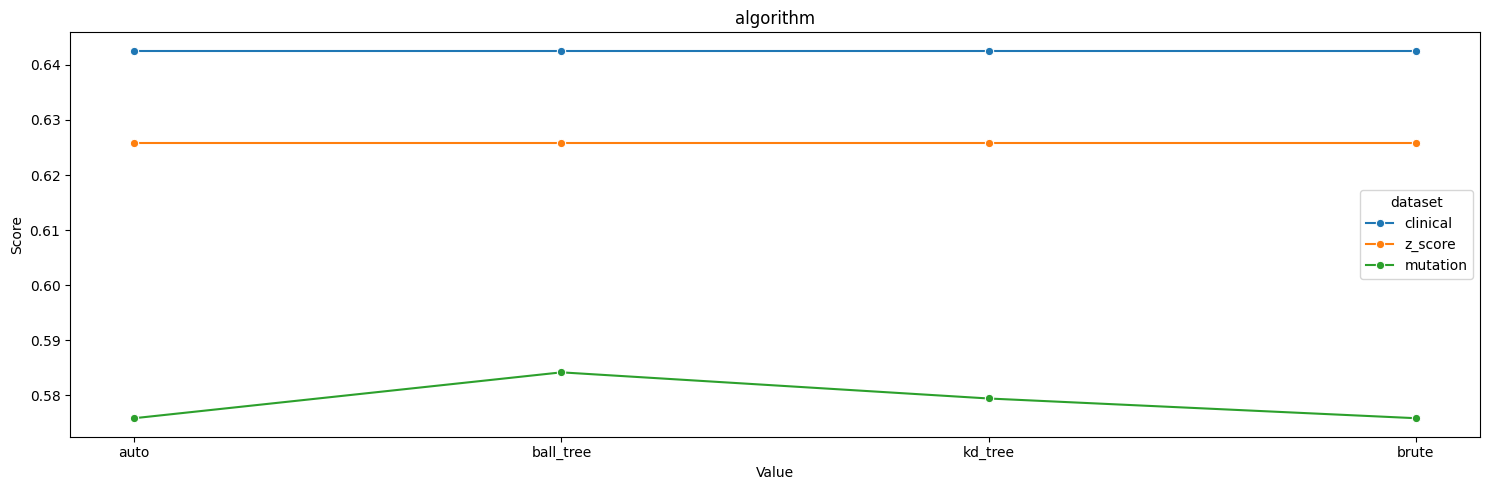

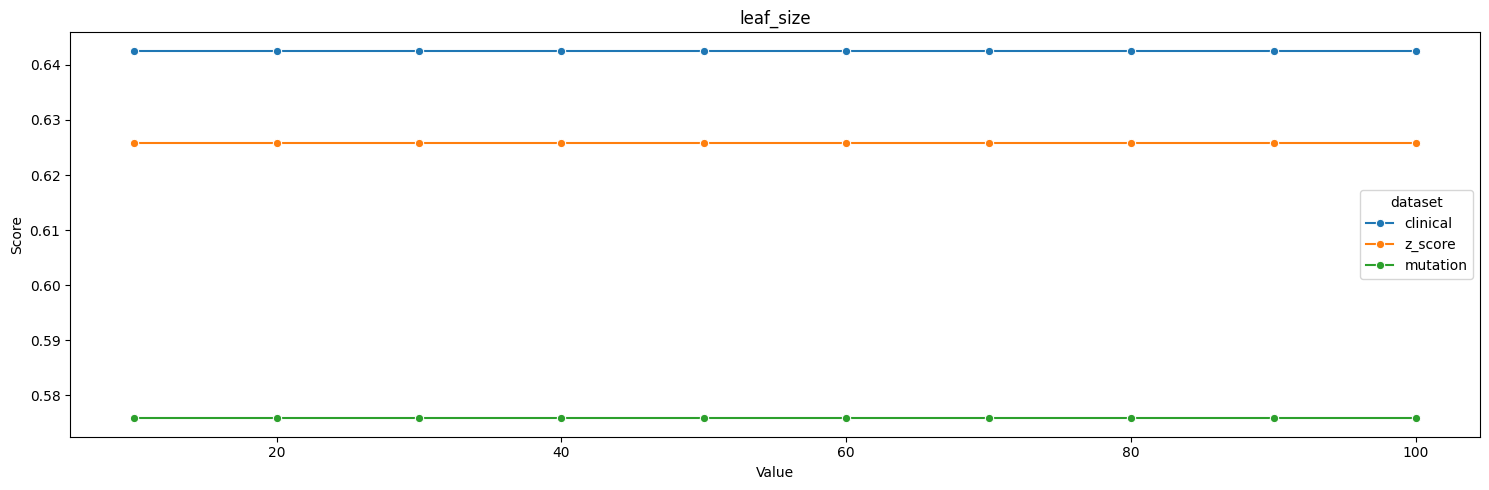

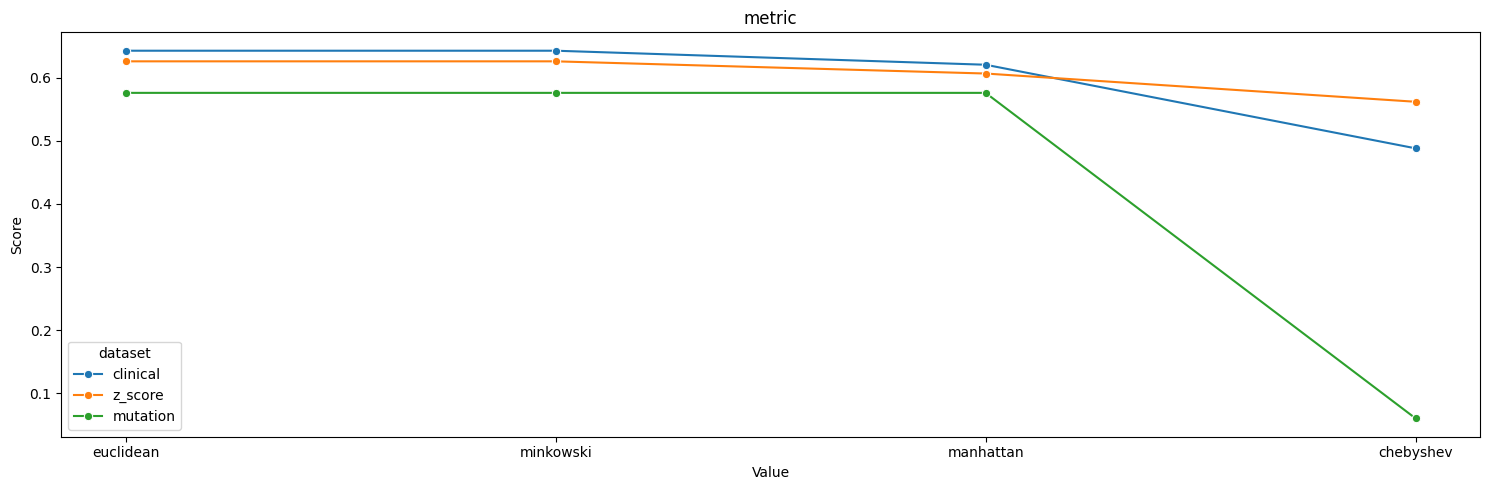

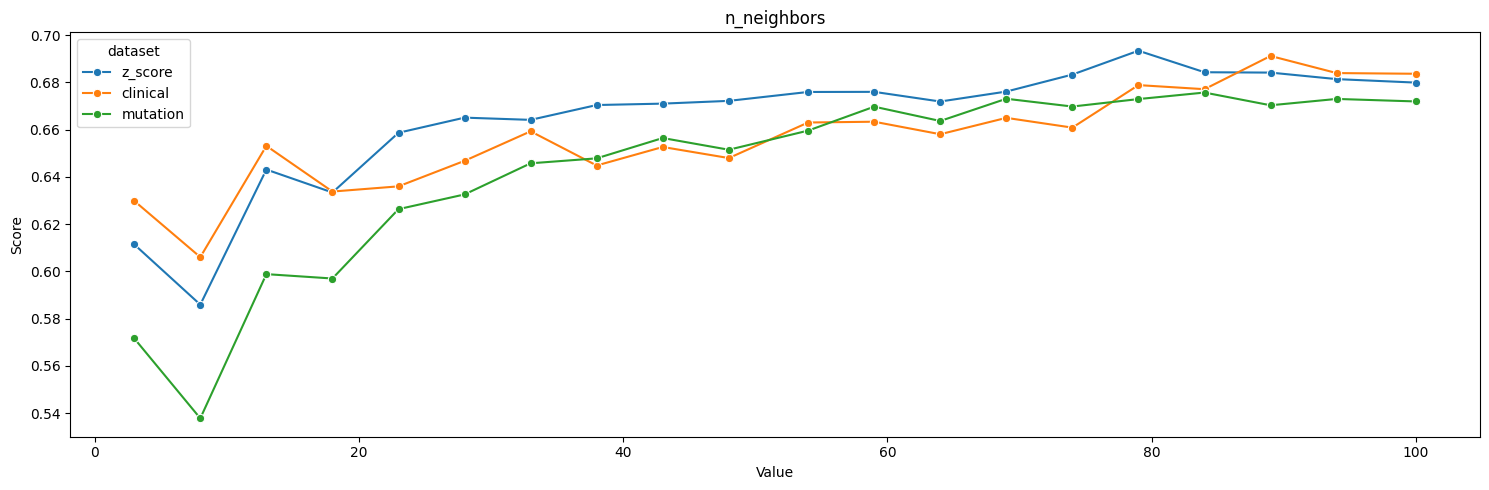

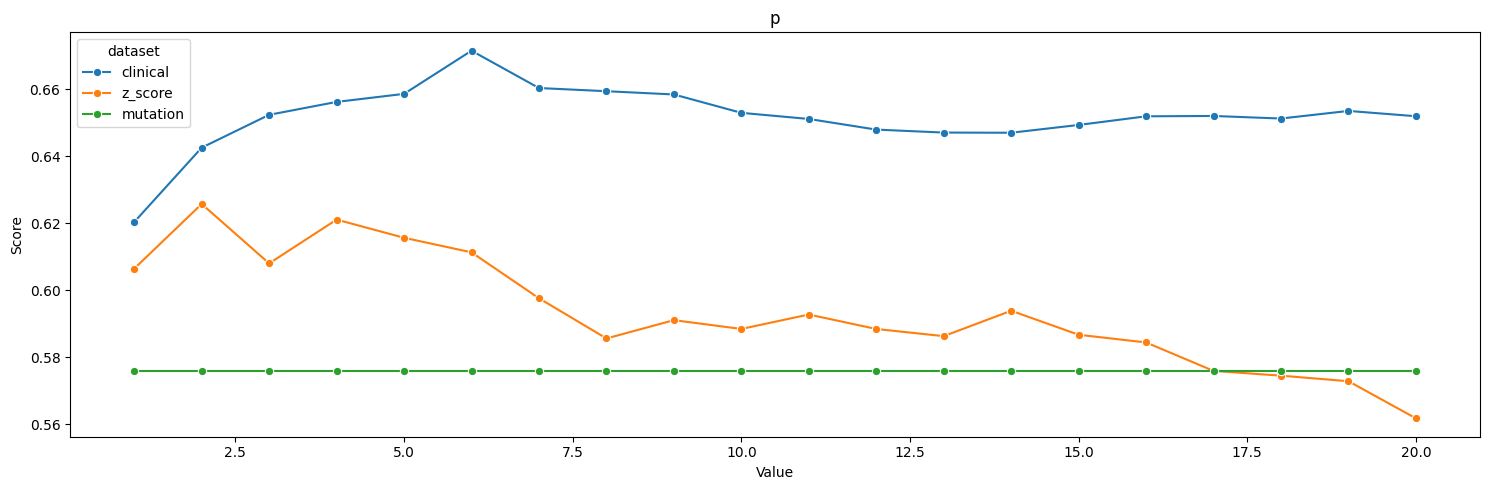

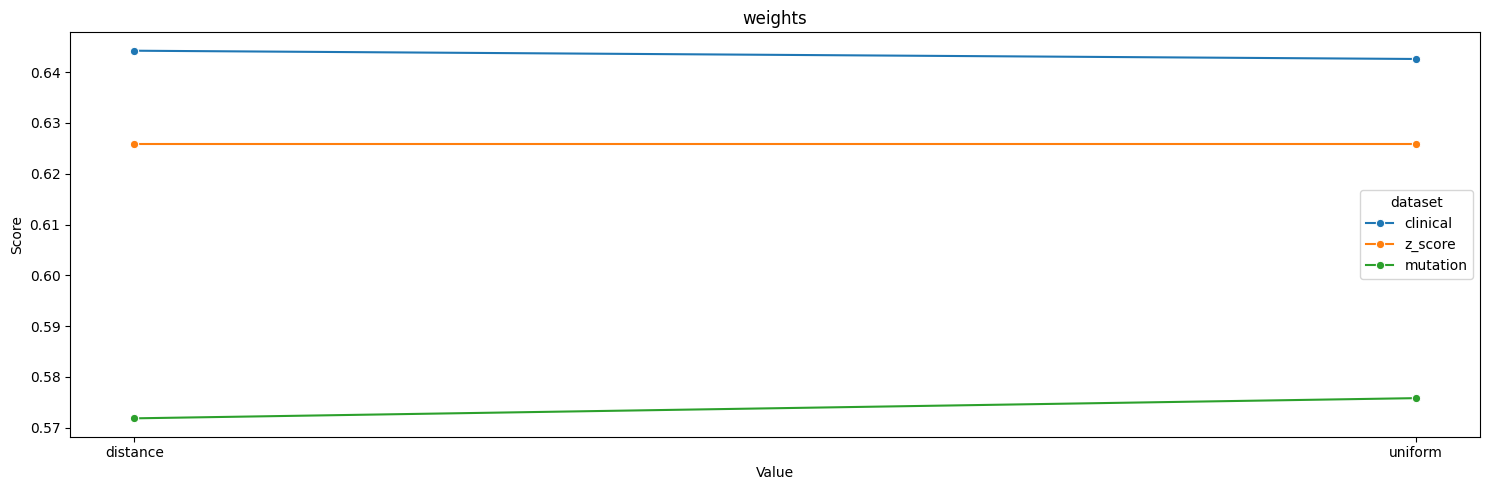

In [47]:
grouped = df.groupby('hyperparameter')

metrics = df.columns[3:]

for row_idx, (name, group) in enumerate(grouped):
    fig = plt.figure(figsize=(15, 5))

    sns.lineplot(data=group, x="value", y="f1", hue='dataset', marker='o')
    plt.title(f'{name}')
    plt.ylabel("Score")
    plt.xlabel("Value")

    plt.tight_layout()
    plt.show()


## Decision Tree (Punto 2)

In [44]:
hyperparameters = [
    ("criterion", ["gini", "entropy", "log_loss"]),
    ("splitter", ["best", "random"]),
    ("max_depth", np.linspace(10, 100, num=10, dtype=int)),
    ("min_samples_split", np.linspace(2, 20, num=10, dtype=int)),
    ("min_samples_leaf", np.linspace(1, 64, num=10, dtype=int)),
    ("max_features", [None, "sqrt", "log2", 2, 4, 6, 8])
]
datasets = [
    ("clinical", X_clinical_train, X_clinical_val, X_clinical_test),
    ("mutation", X_mutation_train, X_mutation_val, X_mutation_test),
    ("z_score", X_z_score_train, X_z_score_val, X_z_score_test)
]

In [48]:
metrics = []
for hyperparameter, values in hyperparameters:
    for value in values:
        if hyperparameter == "criterion":
            model = DecisionTreeClassifier(criterion=value)
        elif hyperparameter == "splitter":
            model = DecisionTreeClassifier(splitter=value)
        elif hyperparameter == "max_depth":
            model = DecisionTreeClassifier(max_depth=value)
        elif hyperparameter == "min_samples_split":
            model = DecisionTreeClassifier(min_samples_split=value)
        elif hyperparameter == "min_samples_leaf":
            model = DecisionTreeClassifier(min_samples_leaf=value)
        elif hyperparameter == "max_features":
            model = DecisionTreeClassifier(max_features=value)
            
        for dataset, X_train, X_val, X_test in datasets:
            cv_results = cross_validate(model, X_train, np.squeeze(y_train), cv=5, scoring=scoring)

            metrics.append([dataset, hyperparameter, value, cv_results["test_accuracy"].mean(), cv_results["test_precision"].mean(), cv_results["test_recall"].mean(), cv_results["test_f1"].mean(), cv_results["test_mcc"].mean()])
            
df = pd.DataFrame(metrics, columns=["dataset",'hyperparameter', 'value', 'accuracy', 'precision', 'recall', 'f1', 'mcc']).sort_values(by=['f1','mcc'], ascending=False)
df

,dataset,hyperparameter,value,accuracy,precision,recall,f1,mcc
87,clinical,min_samples_leaf,29,0.642353,0.665128,0.612252,0.637117,0.286966
90,clinical,min_samples_leaf,36,0.645882,0.678142,0.594096,0.632522,0.296714
93,clinical,min_samples_leaf,43,0.643529,0.681785,0.600993,0.632185,0.296250
99,clinical,min_samples_leaf,57,0.645882,0.680505,0.592032,0.629158,0.299454
102,clinical,min_samples_leaf,64,0.632941,0.660971,0.594070,0.624428,0.269882
...,...,...,...,...,...,...,...,...
73,mutation,min_samples_split,20,0.505882,0.517799,0.491014,0.502395,0.012963
88,mutation,min_samples_leaf,29,0.503529,0.510915,0.502482,0.500725,0.008458
58,mutation,min_samples_split,10,0.497647,0.509894,0.488636,0.498197,-0.004097
19,mutation,max_depth,20,0.508235,0.512898,0.522544,0.491763,0.017164


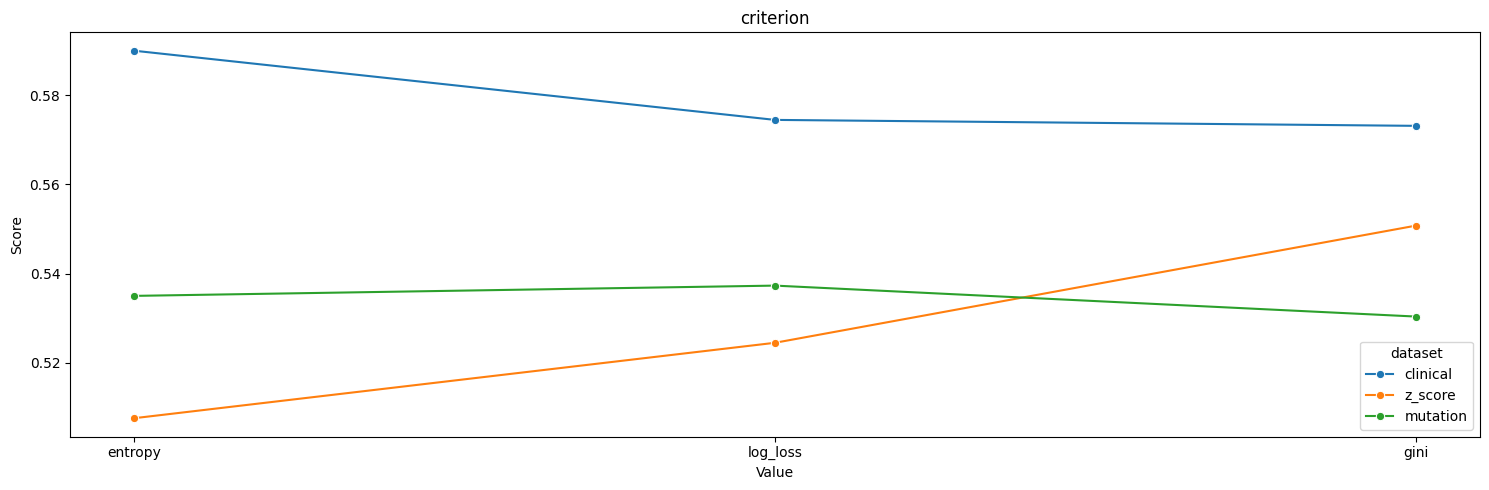

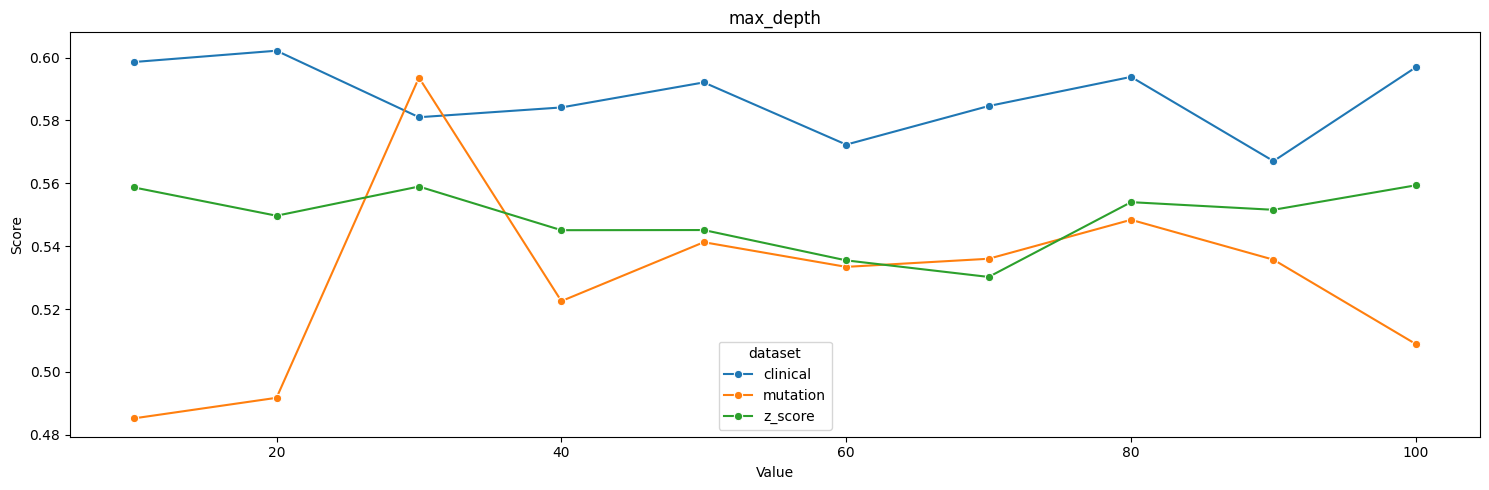

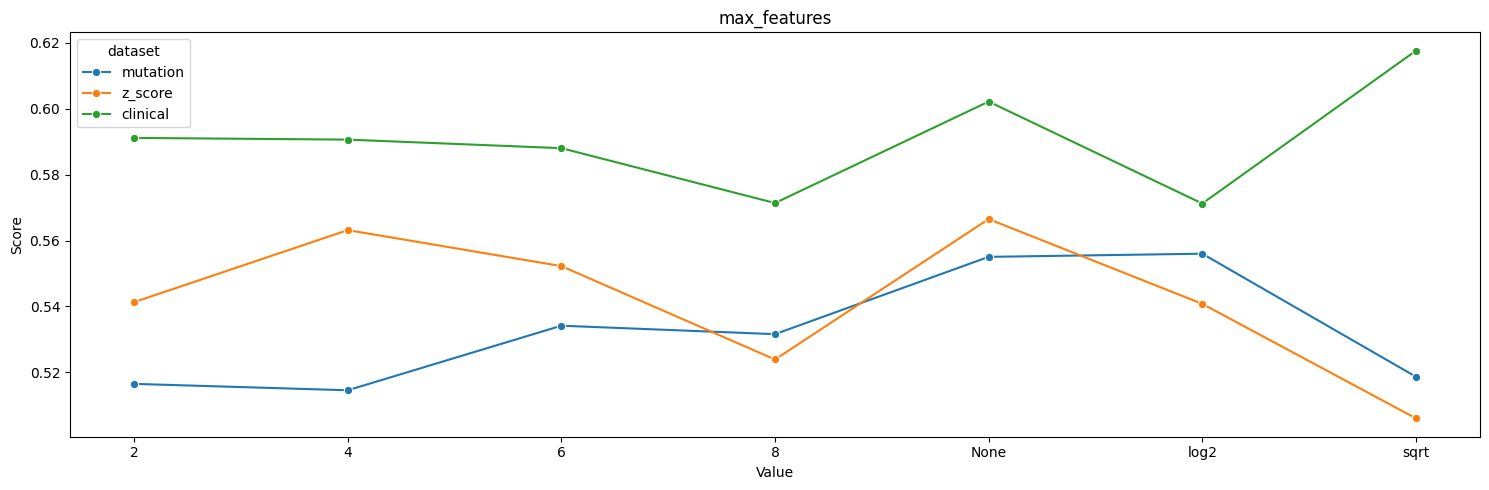

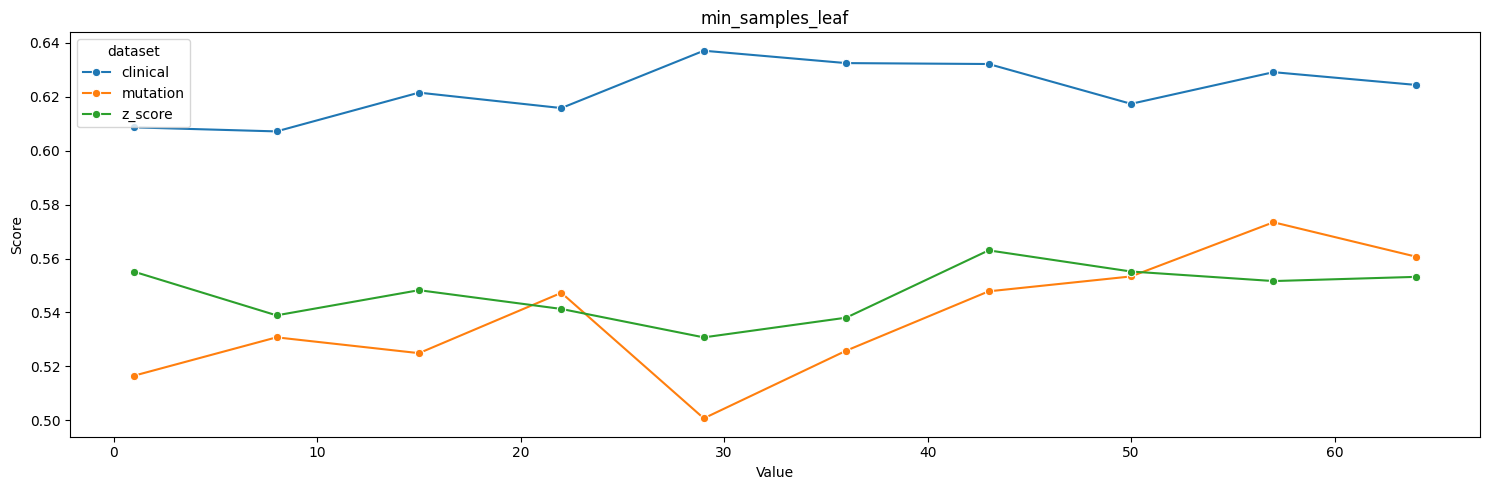

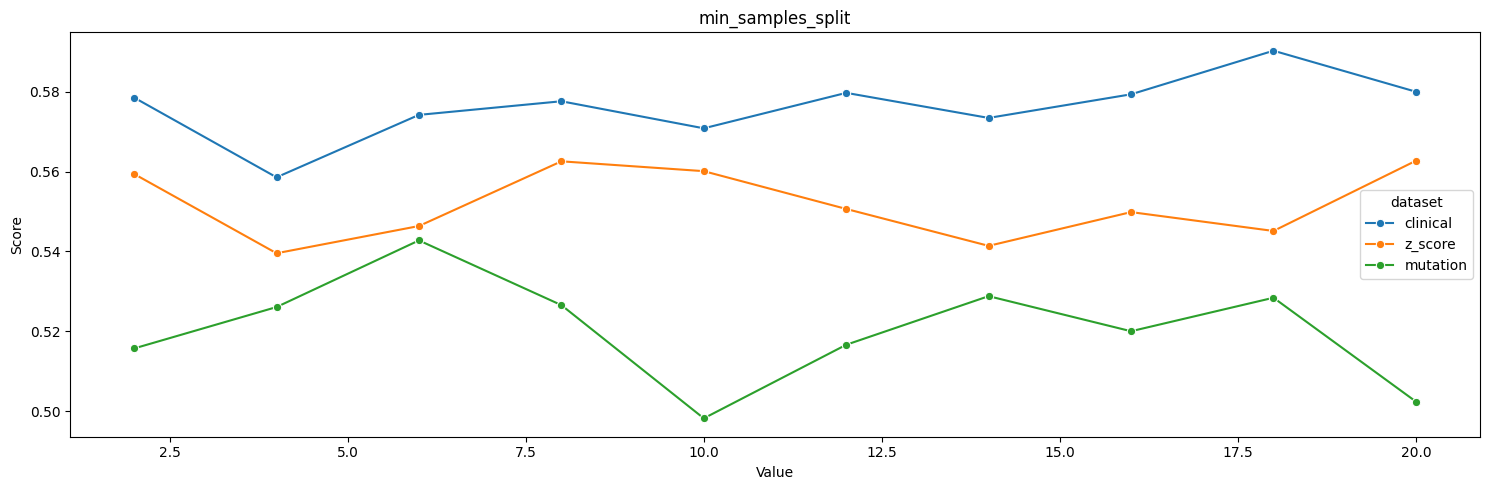

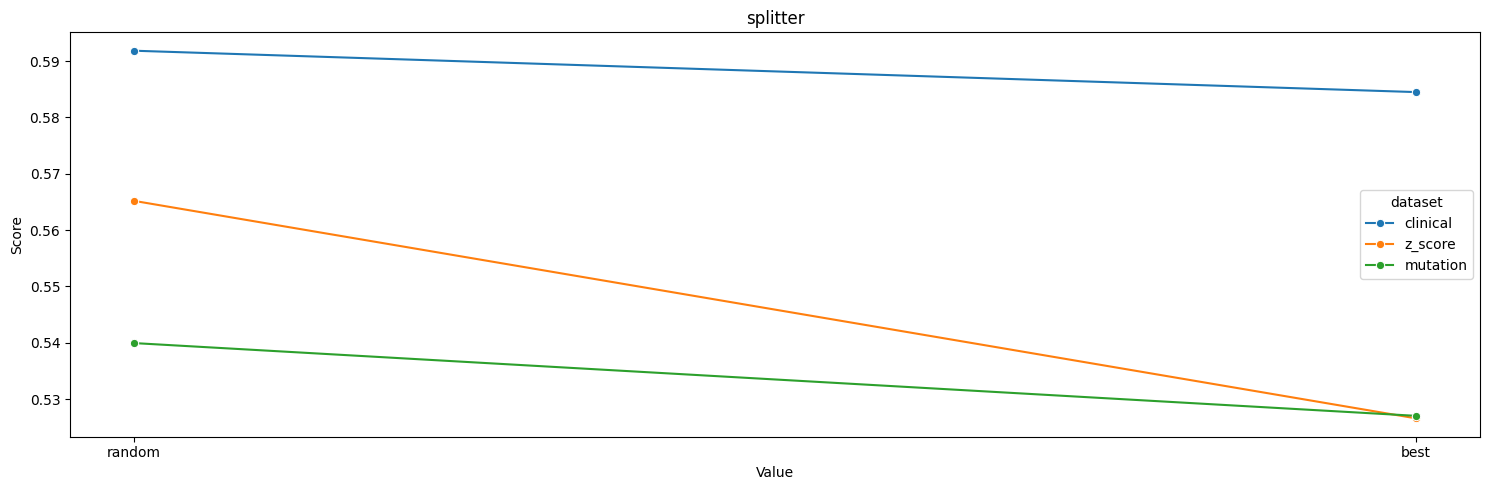

In [51]:
grouped = df.groupby('hyperparameter')

metrics = df.columns[3:]

for row_idx, (name, group) in enumerate(grouped):
    fig = plt.figure(figsize=(15, 5))

    try:
        sns.lineplot(data=group, x="value", y="f1", hue='dataset', marker='o')
    except:
        group["value"] = group["value"].astype(str)
        group.sort_values(by='value', inplace=True)
        sns.lineplot(data=group, x="value", y="f1", hue='dataset', marker='o')
    plt.title(f'{name}')
    plt.ylabel("Score")
    plt.xlabel("Value")

    plt.tight_layout()
    plt.show()

# Random Forest (Punto 2)

In [68]:
hyperparameters = [
    ("n_estimators", np.linspace(100, 500, num=10, dtype=int)),
    ("criterion",["gini", "entropy", "log_loss"]),
    ("max_depth", np.linspace(10, 100, num=10, dtype=int)),
    ("min_samples_split", np.linspace(2, 20, num=10, dtype=int)),
    ("min_samples_leaf",np.linspace(1, 64, num=10, dtype=int)),
    ("max_features",[None, "sqrt", "log2"]),
    ("max_leaf_nodes", np.linspace(10, 100, num=10, dtype=int)),
    ("min_impurity_decrease", np.linspace(0.0, 0.5, num=10)),
    ("bootstrap",[True, False]),
    ("oob_score",[True, False]),
    ("random_state", np.random.randint(0, 1000, 10, dtype=int)),
    ("class_weight",[None, "balanced", "balanced_subsample"]),
    ("ccp_alpha", np.linspace(0.0, 1, num=10, dtype=float)),
    ("max_samples", np.linspace(10, 100, num=10, dtype=int))
]
datasets = [
    ("clinical", X_clinical_train, X_clinical_val, X_clinical_test),
    ("mutation", X_mutation_train, X_mutation_val, X_mutation_test),
    ("z_score", X_z_score_train, X_z_score_val, X_z_score_test)
]

In [69]:
metrics = []
for hyperparameter, values in hyperparameters:
    for value in values:
        if hyperparameter == "n_estimators":
            model = RandomForestClassifier(n_estimators=value)
        elif hyperparameter == "criterion":
            model = RandomForestClassifier(criterion=value)
        elif hyperparameter == "max_depth":
            model = RandomForestClassifier(max_depth=value)
        elif hyperparameter == "min_samples_split":
            model = RandomForestClassifier(min_samples_split=value)
        elif hyperparameter == "min_samples_leaf":
            model = RandomForestClassifier(min_samples_leaf=value)
        elif hyperparameter == "max_features":
            model = RandomForestClassifier(max_features=value)
        elif hyperparameter == "max_leaf_nodes":
            model = RandomForestClassifier(max_leaf_nodes=value)
        elif hyperparameter == "min_impurity_decrease":
            model = RandomForestClassifier(min_impurity_decrease=value)
        elif hyperparameter == "bootstrap":
            model = RandomForestClassifier(bootstrap=value)
        elif hyperparameter == "oob_score":
            model = RandomForestClassifier(oob_score=value)
        elif hyperparameter == "random_state":
            model = RandomForestClassifier(random_state=value)
        elif hyperparameter == "class_weight":
            model = RandomForestClassifier(class_weight=value)
        elif hyperparameter == "ccp_alpha":
            model = RandomForestClassifier(ccp_alpha=value)
        elif hyperparameter == "max_samples":
            model = RandomForestClassifier(max_samples=value)
            
        for dataset, X_train, X_val, X_test in datasets:
            print(f"running {dataset} {hyperparameter} {value}")
            cv_results = cross_validate(model, X_train, np.squeeze(y_train), cv=5, scoring=scoring)

            metrics.append([dataset, hyperparameter, value, cv_results["test_accuracy"].mean(), cv_results["test_precision"].mean(), cv_results["test_recall"].mean(), cv_results["test_f1"].mean(), cv_results["test_mcc"].mean()])


df = pd.DataFrame(metrics, columns=["dataset",'hyperparameter', 'value', 'accuracy', 'precision', 'recall', 'f1', 'mcc']).sort_values(by=['f1','mcc'], ascending=False)
df

running clinical n_estimators 100
running mutation n_estimators 100
running z_score n_estimators 100
running clinical n_estimators 144
running mutation n_estimators 144
running z_score n_estimators 144
running clinical n_estimators 188
running mutation n_estimators 188
running z_score n_estimators 188
running clinical n_estimators 233
running mutation n_estimators 233
running z_score n_estimators 233
running clinical n_estimators 277
running mutation n_estimators 277
running z_score n_estimators 277
running clinical n_estimators 322
running mutation n_estimators 322
running z_score n_estimators 322
running clinical n_estimators 366
running mutation n_estimators 366
running z_score n_estimators 366
running clinical n_estimators 411
running mutation n_estimators 411
running z_score n_estimators 411
running clinical n_estimators 455
running mutation n_estimators 455
running z_score n_estimators 455
running clinical n_estimators 500
running mutation n_estimators 500
running z_score n_estim

,dataset,hyperparameter,value,accuracy,precision,recall,f1,mcc
300,clinical,max_samples,80,0.689412,0.697637,0.697362,0.697351,0.378603
156,clinical,max_leaf_nodes,70,0.683529,0.687488,0.704180,0.695594,0.366323
303,clinical,max_samples,90,0.688235,0.699783,0.688088,0.693788,0.376385
120,clinical,min_samples_leaf,50,0.677647,0.679139,0.706479,0.692171,0.354898
81,clinical,min_samples_split,10,0.682353,0.690633,0.694984,0.692143,0.364597
...,...,...,...,...,...,...,...,...
214,mutation,random_state,707,0.518824,0.532591,0.518443,0.523807,0.038041
247,mutation,class_weight,balanced_subsample,0.515294,0.526587,0.522962,0.523336,0.030805
31,mutation,criterion,gini,0.520000,0.531999,0.513845,0.521917,0.040770
202,mutation,bootstrap,False,0.510588,0.522646,0.511625,0.515970,0.021422


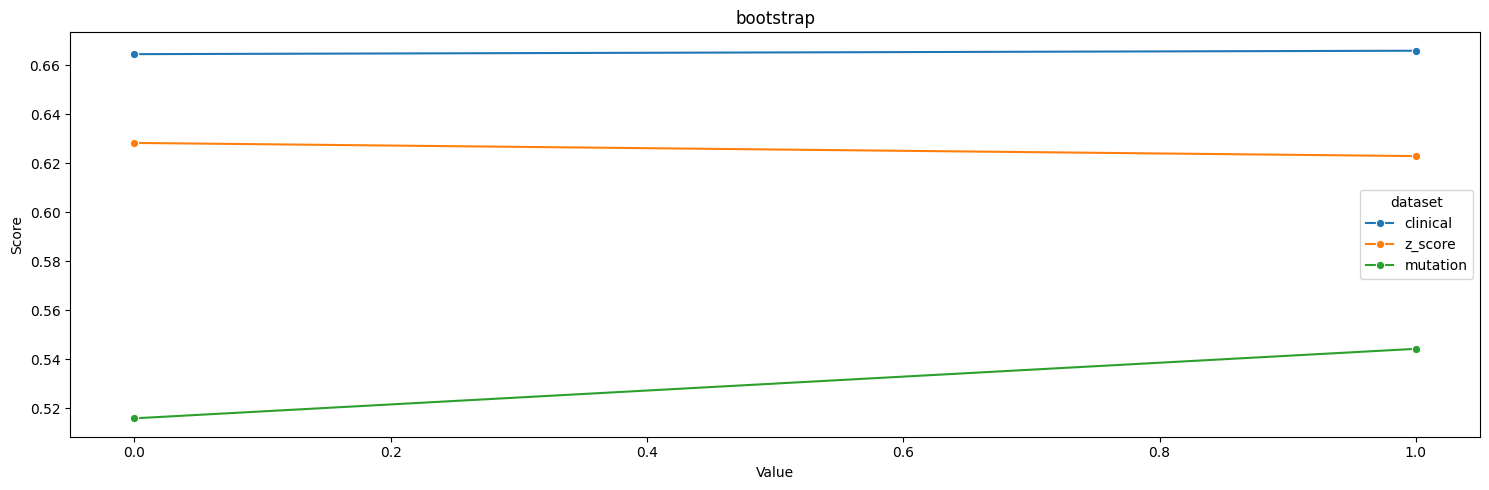

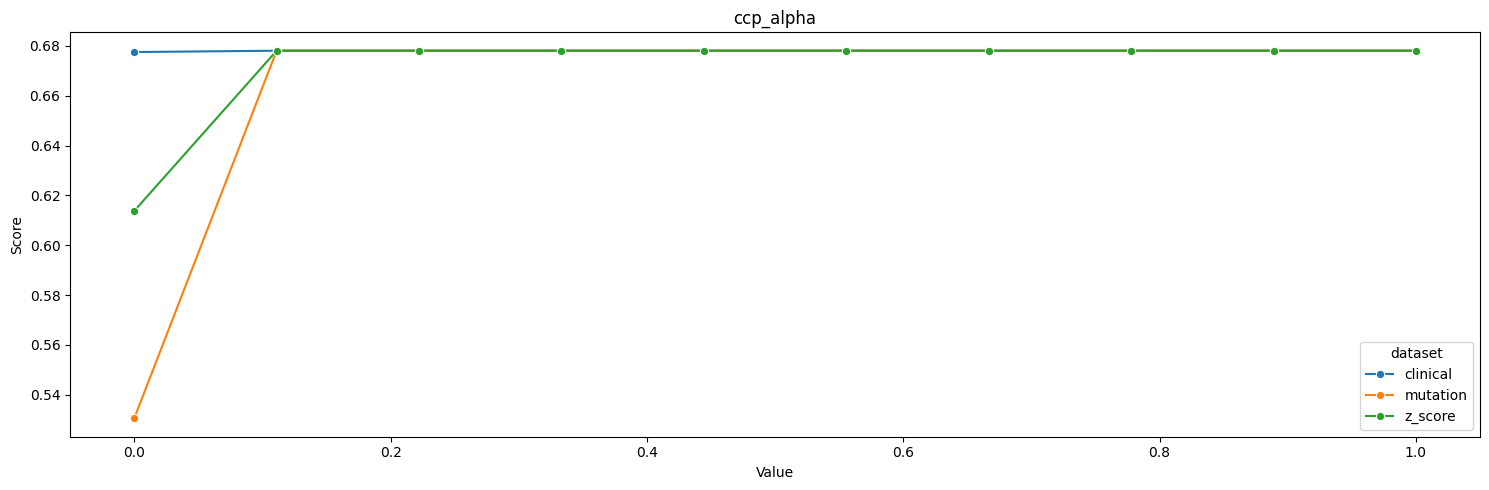

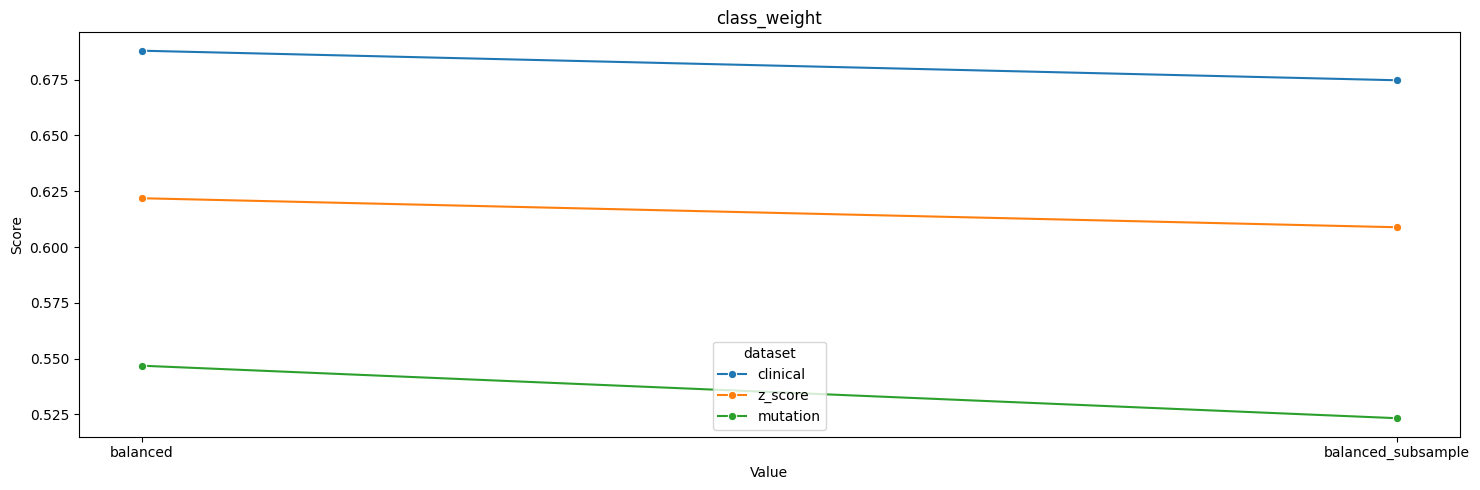

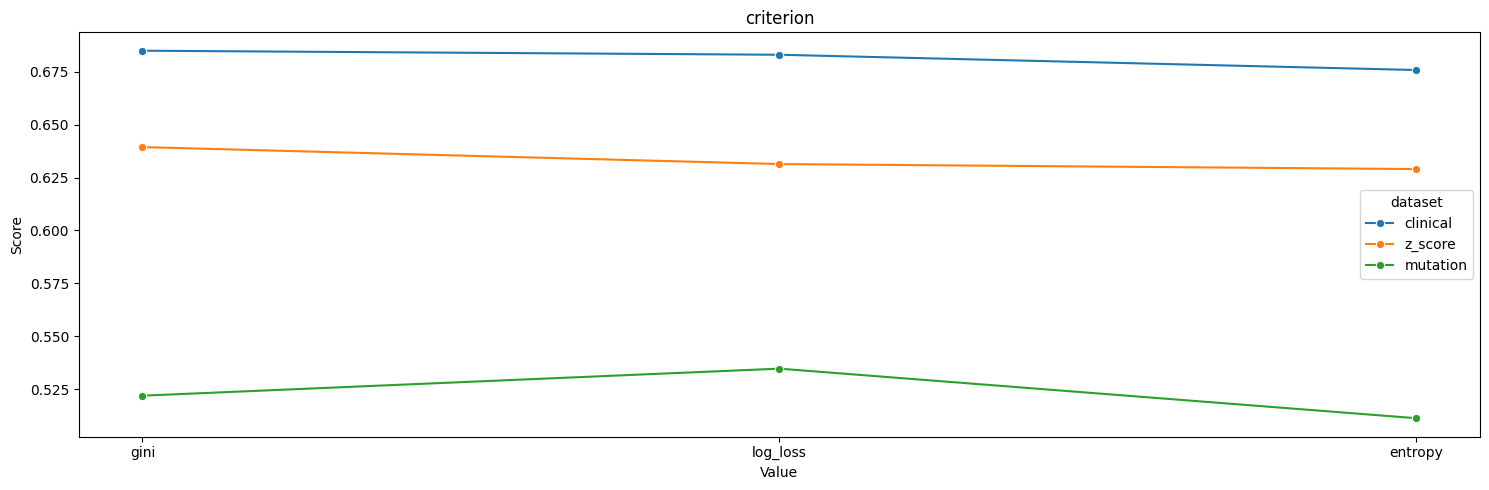

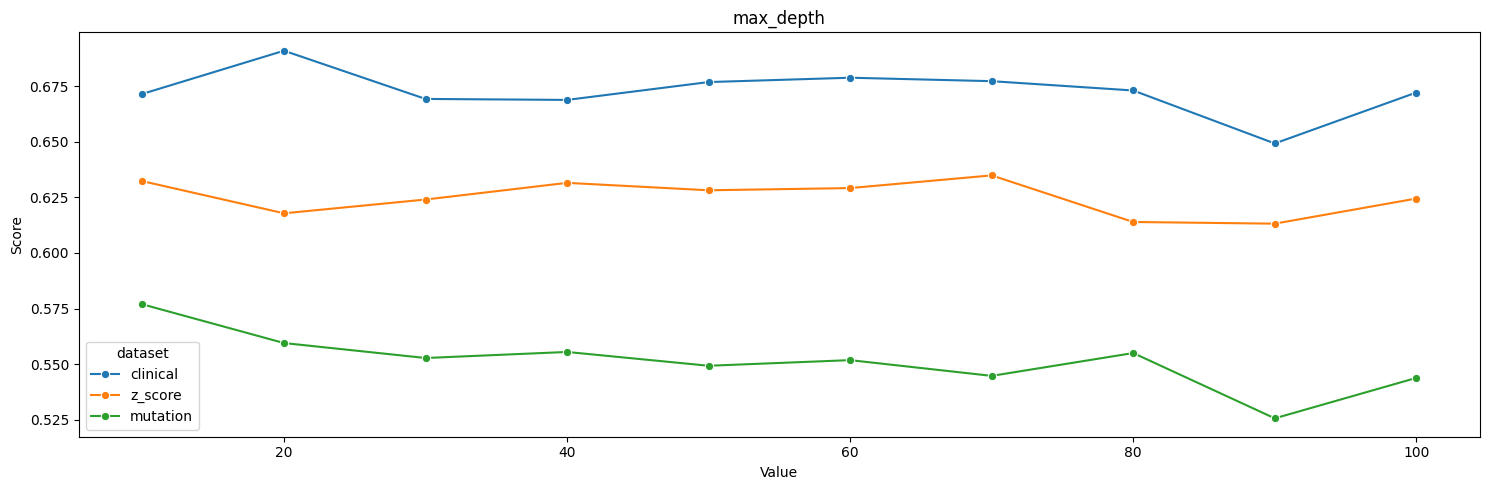

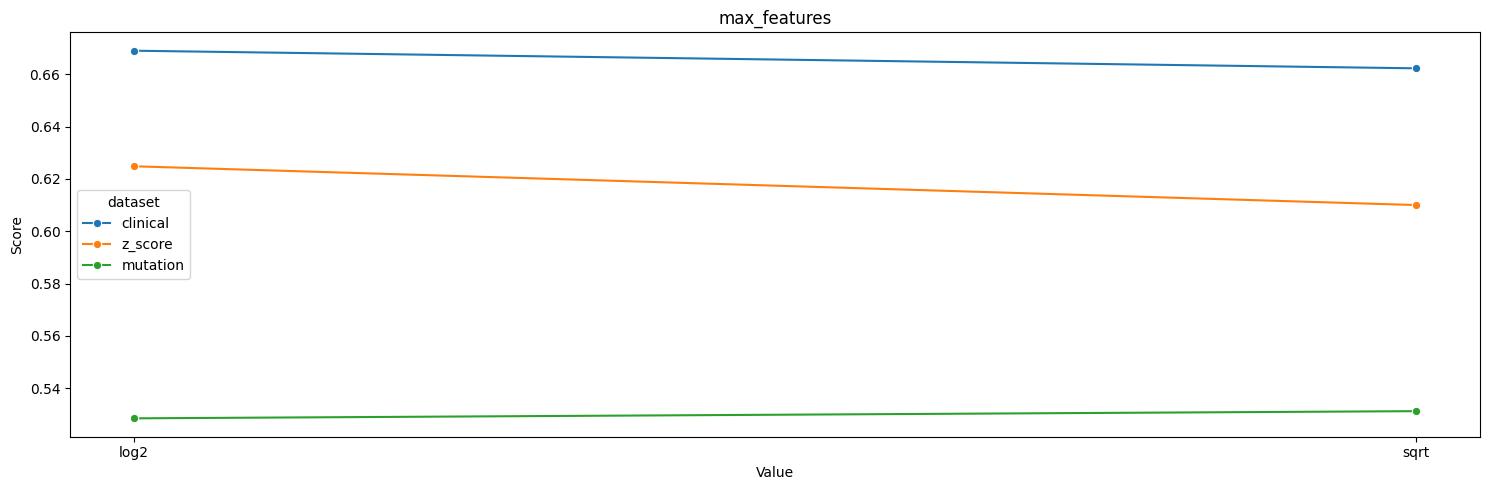

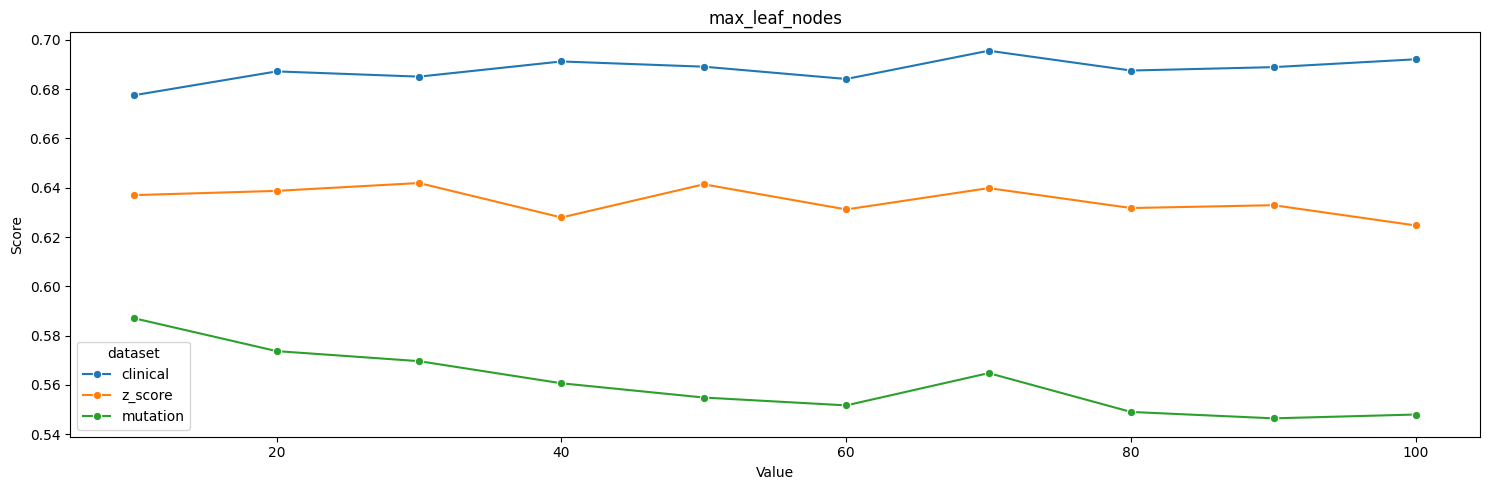

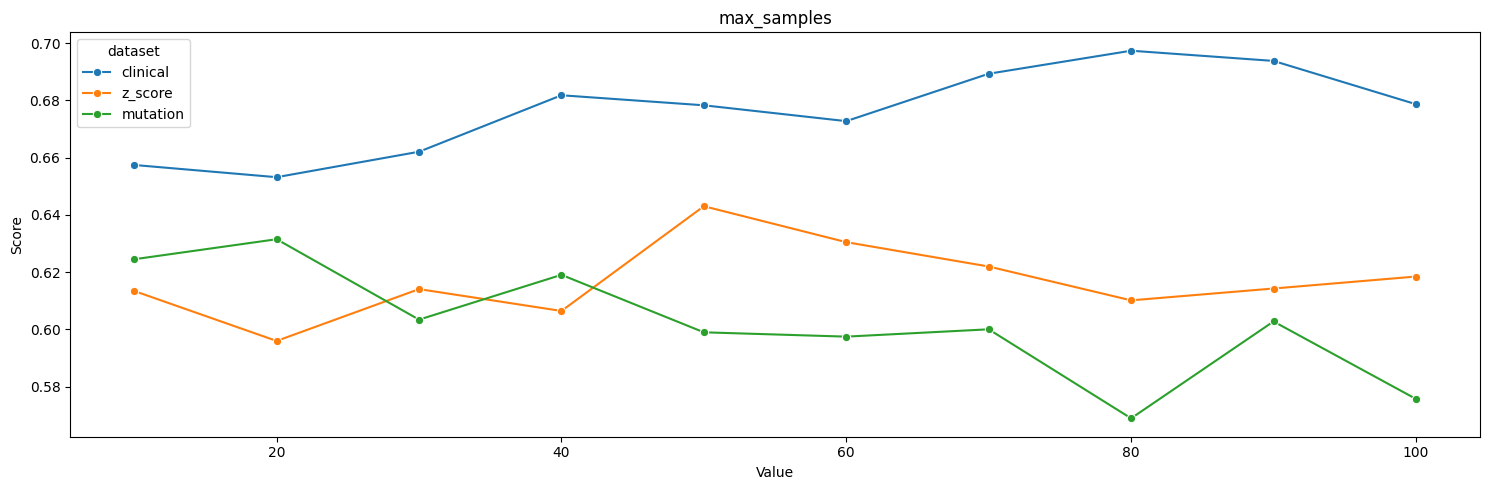

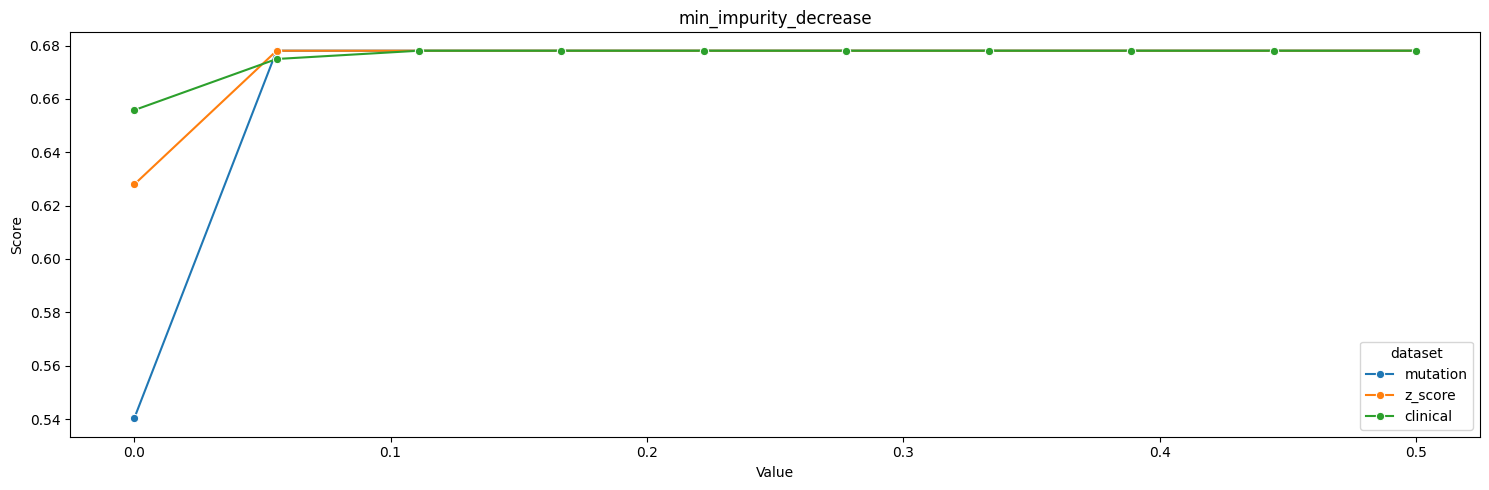

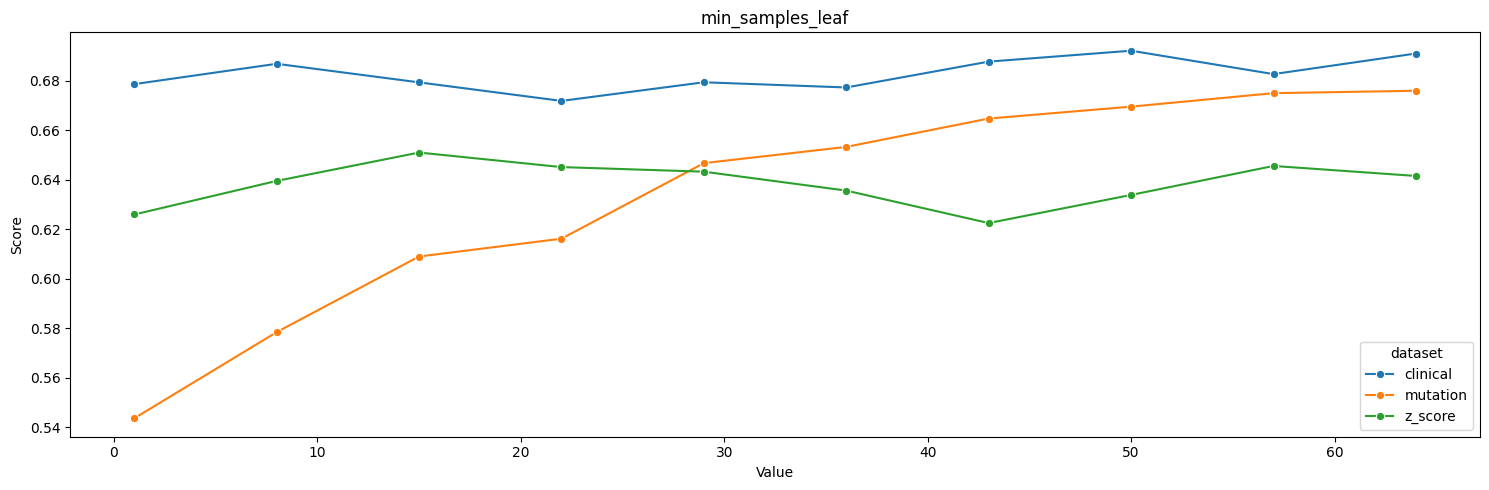

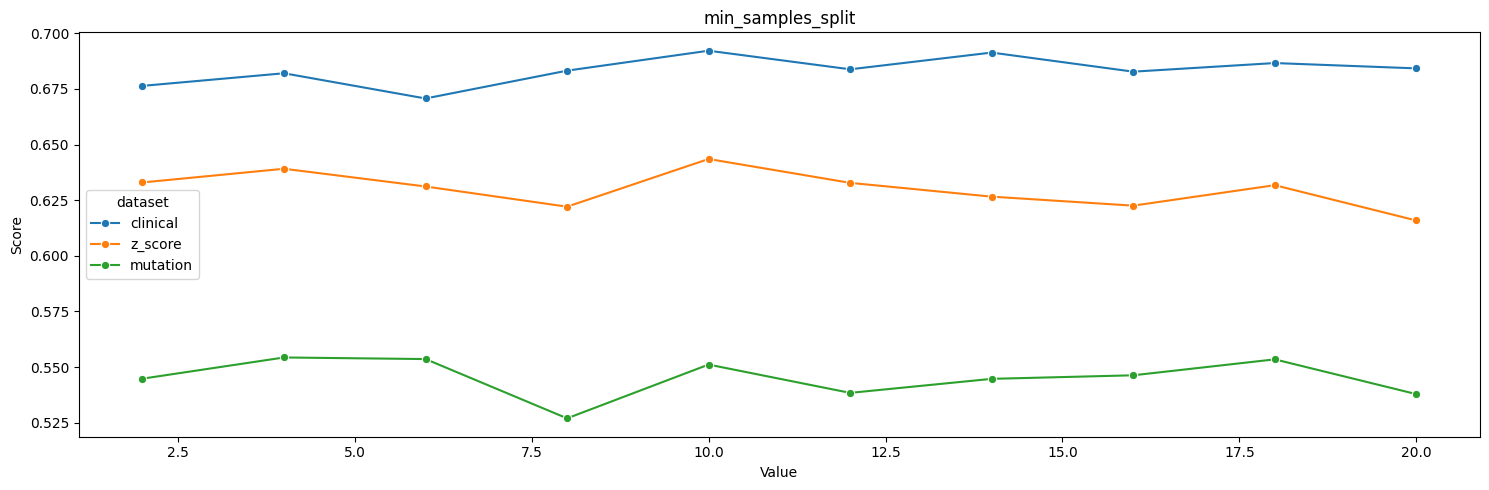

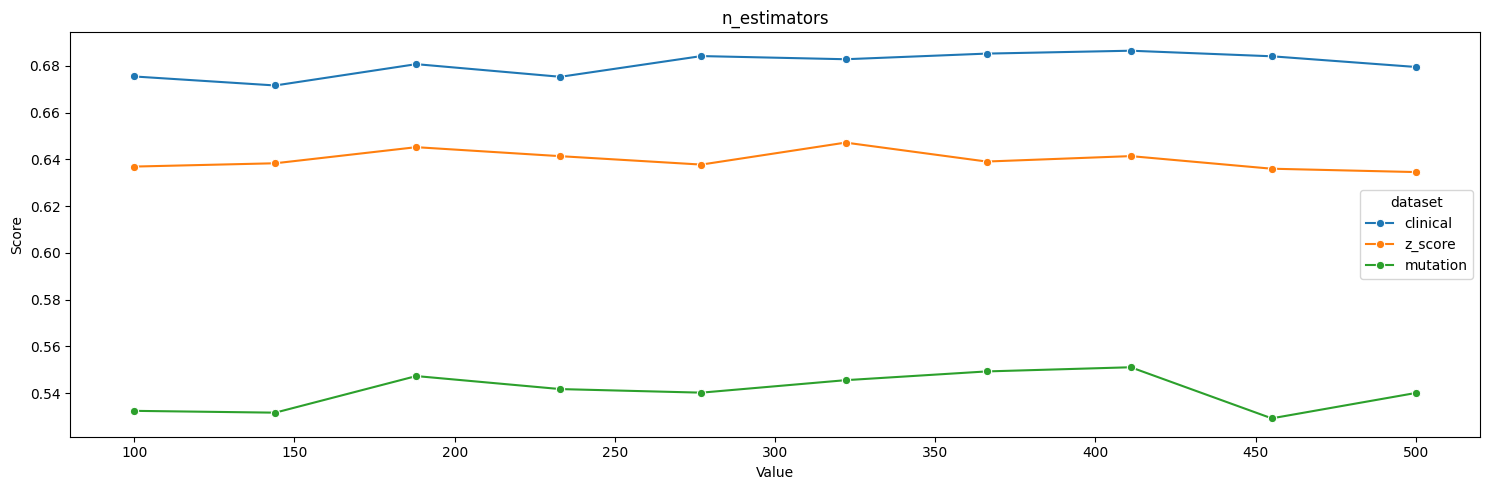

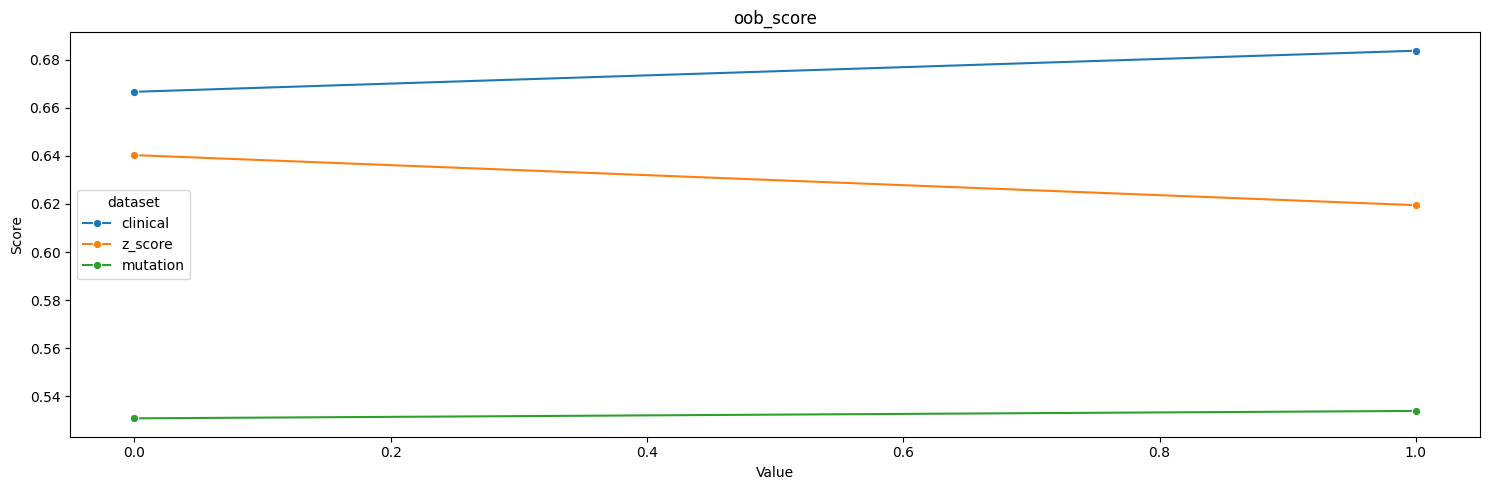

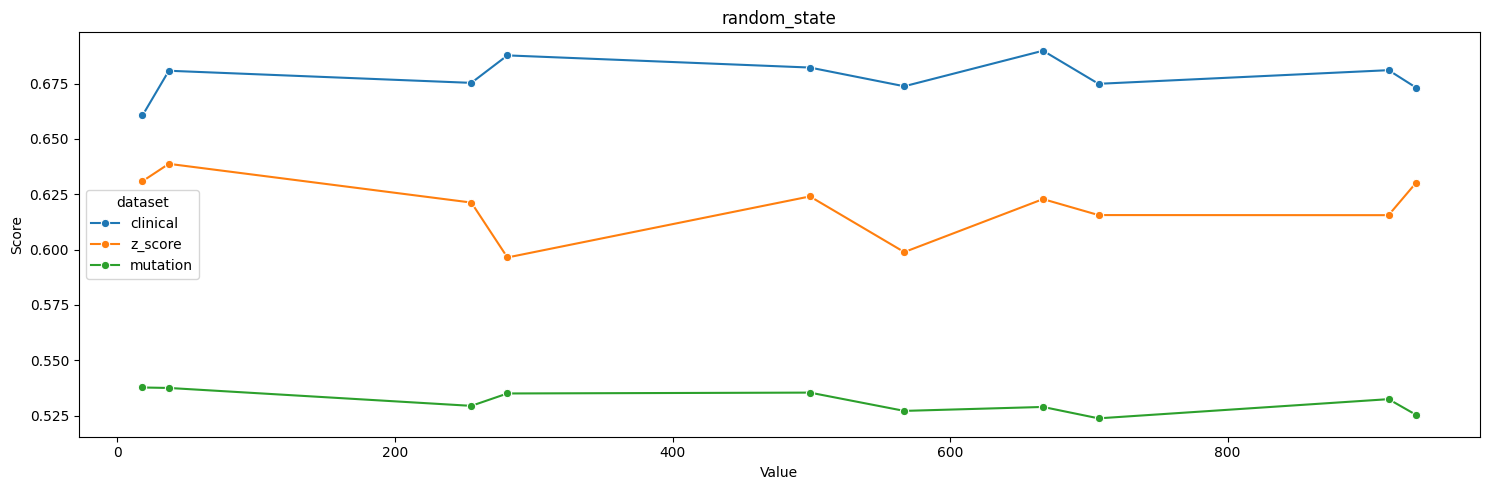

In [71]:
grouped = df.groupby('hyperparameter')

metrics = df.columns[3:]

for row_idx, (name, group) in enumerate(grouped):
    fig = plt.figure(figsize=(15, 5))

    try:
        sns.lineplot(data=group, x="value", y="f1", hue='dataset', marker='o')
    except:
        group["value"] = group["value"].astype(str)
        group.sort_values(by='value', inplace=True)
        sns.lineplot(data=group, x="value", y="f1", hue='dataset', marker='o')
    plt.title(f'{name}')
    plt.ylabel("Score")
    plt.xlabel("Value")

    plt.tight_layout()
    plt.show()

# Ensemble

In [72]:
model_clinical = RandomForestClassifier()
model_z_score = SVC()
model_mutation = RandomForestClassifier()

model_clinical.fit(X_clinical_train, y_train)
model_z_score.fit(X_z_score_train, y_train)
model_mutation.fit(X_mutation_train, y_train)

pred_clinical = model_clinical.predict(X_clinical_val)
pred_z_score = model_z_score.predict(X_z_score_val)
pred_mutation = model_mutation.predict(X_mutation_val)

X_meta_train = np.column_stack((pred_clinical, pred_z_score, pred_mutation))

y_meta_train = y_val

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [73]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_meta_train)

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [74]:
pred_clinical_test = model_clinical.predict(X_clinical_test)
pred_z_score_test = model_z_score.predict(X_z_score_test)
pred_mutation_test = model_mutation.predict(X_mutation_test)

X_meta_test = np.column_stack((pred_clinical_test, pred_z_score_test, pred_mutation_test))

final_predictions = meta_model.predict(X_meta_test)

In [75]:
stacked_accuracy = accuracy_score(y_test, final_predictions)
stacked_accuracy

0.7058823529411765

## Cross validation

In [76]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

meta_features = np.zeros((len(X_clinical_train), 3))

In [80]:
model_clinical = RandomForestClassifier()
model_z_score = SVC()
model_mutation = RandomForestClassifier()
for train_idx, val_idx in kf.split(X_clinical_train):
    X_ctrain, X_cval = X_clinical_train.to_numpy()[train_idx], X_clinical_train.to_numpy()[val_idx]
    X_ztrain, X_zval = X_z_score_train.to_numpy()[train_idx], X_z_score_train.to_numpy()[val_idx]
    X_mtrain, X_mval = X_mutation_train.to_numpy()[train_idx], X_mutation_train.to_numpy()[val_idx]

    y_train_cv, y_val_cv = y_train.to_numpy()[train_idx], y_train.to_numpy()[val_idx]

    model_clinical.fit(X_ctrain, y_train_cv)
    model_z_score.fit(X_ztrain, y_train_cv)
    model_mutation.fit(X_mtrain, y_train_cv)

    pred_clinical = model_clinical.predict(X_cval)
    pred_z_score = model_z_score.predict(X_zval)
    pred_mutation = model_mutation.predict(X_mval)

    meta_features[val_idx, 0] = pred_clinical
    meta_features[val_idx, 1] = pred_z_score
    meta_features[val_idx, 2] = pred_mutation

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-v

In [78]:
meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train.to_numpy())

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [79]:
stacked_metrics = []

for train_idx, val_idx in kf.split(X_clinical_train):
    model_clinical.fit(X_clinical_train.to_numpy()[train_idx], y_train.to_numpy()[train_idx])
    model_z_score.fit(X_z_score_train.to_numpy()[train_idx], y_train.to_numpy()[train_idx])
    model_mutation.fit(X_mutation_train.to_numpy()[train_idx], y_train.to_numpy()[train_idx])

    pred_clinical = model_clinical.predict(X_clinical_train.to_numpy()[val_idx])
    pred_z_score = model_z_score.predict(X_z_score_train.to_numpy()[val_idx])
    pred_mutation = model_mutation.predict(X_mutation_train.to_numpy()[val_idx])

    X_meta_test = np.column_stack((pred_clinical, pred_z_score, pred_mutation))
    final_predictions = meta_model.predict(X_meta_test)

    accuracy = accuracy_score(y_train.to_numpy()[val_idx], final_predictions)
    precision = precision_score(y_train.to_numpy()[val_idx], final_predictions, average='weighted')
    recall = recall_score(y_train.to_numpy()[val_idx], final_predictions, average='weighted')
    f1 = f1_score(y_train.to_numpy()[val_idx], final_predictions, average='weighted')
    mcc = matthews_corrcoef(y_train.to_numpy()[val_idx], final_predictions)

    stacked_metrics.append([accuracy, precision, recall, f1, mcc])

avg_stacked_metrics = np.mean(stacked_metrics, axis=0)

pd.DataFrame(avg_stacked_metrics, index=["accuracy", "precision", "recall", "f1", "mcc"], columns=["mean"])

/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/diego/miniconda3/envs/pandas-env/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-v

,mean
accuracy,0.672941
precision,0.674038
recall,0.672941
f1,0.672776
mcc,0.344873


## Conclusion
Mejora un poco con respecto a la tirada de moneda